In [1]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 1

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, LSTM, Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling3D, TimeDistributed, ConvLSTM2D
from keras.layers.core import Permute, Reshape
from keras import backend as K


In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10
    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features


In [3]:
path='C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/data/'

def get_train_and_validate_data(path=path):
    Train_data=np.load(path+'Data_train_all.npz')
    Labels=Train_data['arr_1']
    Features_video=Train_data['arr_3']

    Labels = one_hot_encoding(Labels)
    
    randomize = np.arange(len(Labels))
    np.random.shuffle(randomize)
    
    Labels = Labels[randomize]
    Features_video = Features_video[randomize]
    
    #Features_video = Features_video.astype('float32')
    #Features_video /= 255
    
    new_Labels = np.split(Labels,[Labels.shape[0] - 1000])
    new_Features_video = np.split(Features_video,[Features_video.shape[0] - 1000])
    
    return new_Labels[0],new_Features_video[0],new_Labels[1],new_Features_video[1]


def get_test_data(path=path):
    Train_data=np.load(path+'Data_test_71.pkl',allow_pickle=True)
    Labels=Train_data[1]
    Features_video=Train_data[3]

    Labels = one_hot_encoding(Labels)
    
    #new_Features_video = Features_video.astype('float32')
    #new_Features_video /= 255

    return Labels,Features_video

In [4]:
Labels,Features_video,Labels2,Features_video2 = get_train_and_validate_data()
print(Labels.shape,Features_video.shape)
print('Train Classes distribution: ',np.sum(Labels, axis = 0))

print(Labels2.shape, Features_video2.shape)
print('Validate Classes distribution: ',np.sum(Labels2, axis = 0))

Labels3,Features_video3 = get_test_data()
print(Labels3.shape,Features_video3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis = 0))

(10976, 7) (10976, 45, 64, 64, 3)
Train Classes distribution:  [1685. 2184. 1192. 1705. 1163. 1627. 1420.]
(1000, 7) (1000, 45, 64, 64, 3)
Validate Classes distribution:  [148. 176. 116. 143. 109. 152. 156.]
(1377, 7) (1377, 45, 64, 64, 3)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


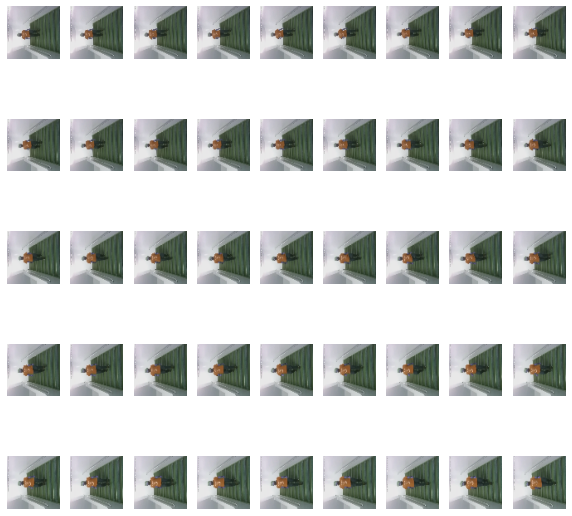

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(45):
    ax = plt.subplot(5, 9, i + 1)
    plt.imshow(Features_video[0][i])
    plt.axis("off")

# Video Model

In [6]:
num_classes=7

def full_video_model():  
    print('building the model ... ')    
    
    #c3d model
    model = Sequential()
    
    # 1st layer group
    model.add(Conv3D(32, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv1', input_shape=(45, 64, 64, 3)))
    model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='valid', name='pool1'))
    
    # 2nd layer group
    model.add(Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1),activation='relu',padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool2'))
    
    # 3rd layer group
    model.add(Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv3a'))
    model.add(Conv3D(64, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool3'))
    
    # 4th layer group
    model.add(Conv3D(128, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv4a'))
    model.add(Conv3D(128, kernel_size=(3,3,3), strides=(1,1,1), activation='relu', padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool4'))
    
    model.add(Flatten())
    # FC layers group
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(Dropout(.5))
    
    model.add(Dense(1024, activation='relu', name='fc2'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu', name='fc3'))
    
    model.add(Dense(num_classes, activation='softmax', name = 'OUTPUT'))
    
    return model

In [7]:
video_model = full_video_model()

building the model ... 


In [8]:
video_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 45, 64, 64, 32)    2624      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 45, 32, 32, 32)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 45, 32, 32, 64)    55360     
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 22, 16, 16, 64)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 22, 16, 16, 64)    110656    
_________________________________________________________________
conv3b (Conv3D)              (None, 22, 16, 16, 64)    110656    
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 11, 8, 8, 64)      0

In [9]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models/video_model_checkpoint'

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)
earlystopper = EarlyStopping(monitor='val_accuracy',patience=5)

In [10]:
batch_size = 64
epochs = 50

video_model.compile(loss=keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = video_model.fit(Features_video, Labels,
                    verbose=0,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=batch_size,
                    callbacks=[checkpointer,earlystopper,TqdmCallback(verbose=2)],
                    validation_data=(Features_video2, Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.48700, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\video_model_checkpoint
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\video_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.48700 to 0.87400, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\video_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\video_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.87400 to 0.89400, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\video_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\video_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy did not improve from 0.89400


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy did not improve from 0.89400


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy did not improve from 0.89400


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy did not improve from 0.89400


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy improved from 0.89400 to 0.94700, saving model to C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\video_model_checkpoint
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/ECE 209AS ML/TimeAwareness/Baseline Models\video_model_checkpoint\assets


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy did not improve from 0.94700


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy did not improve from 0.94700


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy did not improve from 0.94700


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy did not improve from 0.94700


  0%|          | 0.00/172 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy did not improve from 0.94700
---Time 1273.6017472743988 seconds ---


In [11]:
from keras.models import load_model

video_model = load_model(model_path)

In [12]:
#Train Accuracy
video_model.evaluate(Features_video,Labels)

343/343 [==============================] - 38s 110ms/step - loss: 0.1691 - accuracy: 0.9506


[0.16905026137828827, 0.9506195187568665]

In [13]:
#valid Accuracy
video_model.evaluate(Features_video2,Labels2)

32/32 [==============================] - 3s 107ms/step - loss: 0.1706 - accuracy: 0.9470


[0.17058904469013214, 0.9470000267028809]

In [14]:
#Test Accuracy
video_model.evaluate(Features_video3,Labels3)

44/44 [==============================] - 5s 107ms/step - loss: 1.5458 - accuracy: 0.7901


[1.5457714796066284, 0.790123462677002]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


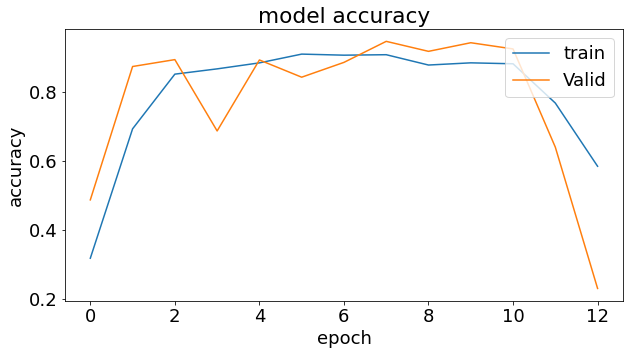

In [15]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()


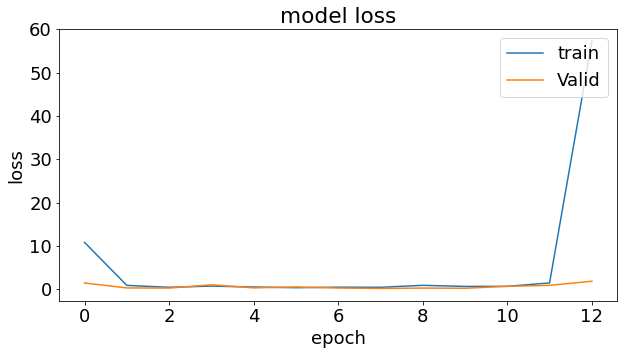

In [16]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()